In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL

from forecasting.preprocessing import (
    load_csv, build_month_start_date, normalize_sectors,
    transportation_from_biofuels, pivot_sector_timeseries,
    trim_period, maybe_log_transform, invert_log_transform
)

from forecasting.models import (
    seasonal_naive,
    forecast_rw_recursive,
    forecast_arima_recursive,
    forecast_sarima_recursive,
    forecast_var_recursive,
)

from forecasting.evaluation import rmsfe
from pathlib import Path

In [2]:
CSV_PATH   = 'data/US_renewable_forecasting.csv'
MACRO_PATH = 'data/macro_vars.csv'

TEST_SIZE_RATIO = 0.2
VAR_LAGS = 4

VAR_SECTOR_COLS = [
    "Commercial",
    "Residential",
    "Transportation",
    "Industrial",
    "Electric Power",
]

def plot_stl(y: pd.Series, period=12, title=None):
    """STL decomposition per una singola serie."""
    res = STL(y, period=period).fit()
    fig = res.plot()
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [3]:
# === Renewable data ===
df = load_csv(CSV_PATH)
df = build_month_start_date(df)
df = normalize_sectors(df)
df = transportation_from_biofuels(df)

ts = pivot_sector_timeseries(df)
ts = trim_period(ts, start='1995-01-01')

ts.head()

Sector,Commercial,Electric Power,Industrial,Residential,Transportation
date,,,,,
1995-01-01,9.784,119.949,148.698,48.115,9.237
1995-02-01,8.713,114.390,123.271,44.051,8.420
1995-03-01,9.401,128.739,148.709,49.761,10.344
1995-04-01,10.126,123.899,168.353,48.832,9.554
1995-05-01,8.948,123.030,141.198,50.852,8.003


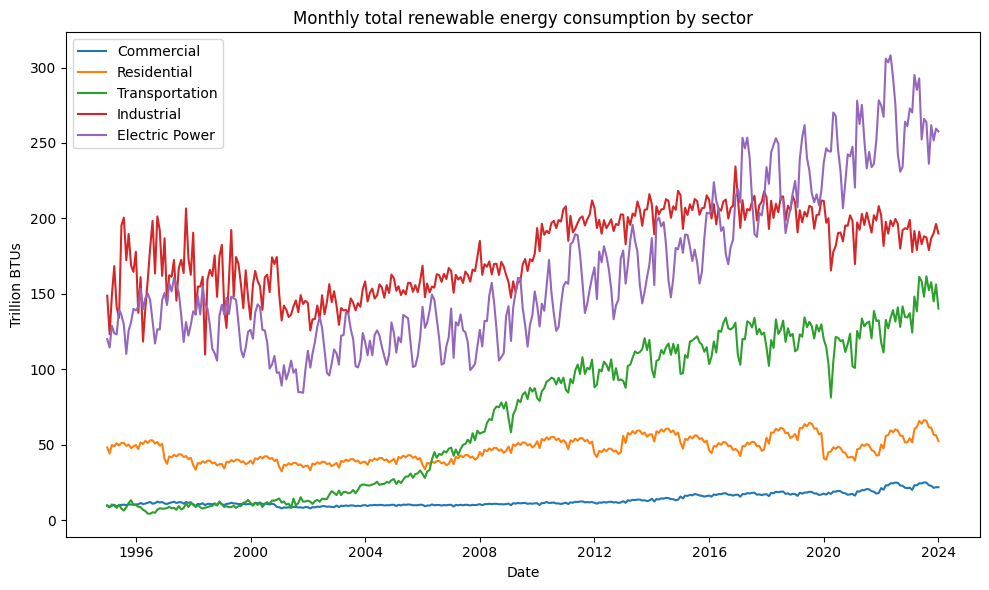

In [4]:
# === Descriptive plots ===
plt.figure(figsize=(10, 6))
for col in VAR_SECTOR_COLS:
    plt.plot(ts.index, ts[col], label=col)

plt.title("Monthly total renewable energy consumption by sector")
plt.xlabel("Date")
plt.ylabel("Trillion BTUs")
plt.legend()
plt.tight_layout()
plt.show()

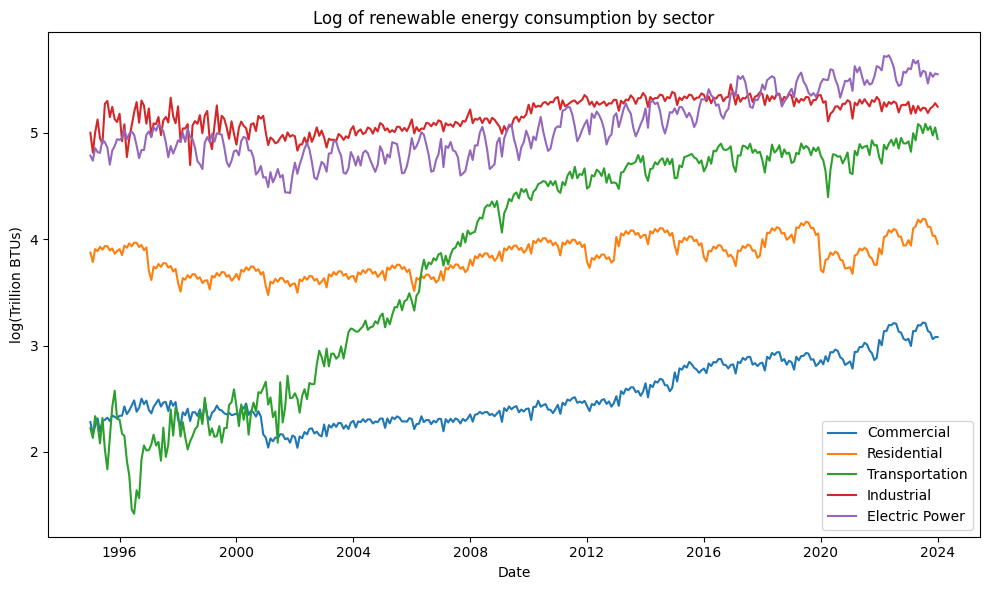

In [5]:
ts_log = np.log(ts)

plt.figure(figsize=(10, 6))
for col in VAR_SECTOR_COLS:
    plt.plot(ts_log.index, ts_log[col], label=col)

plt.title("Log of renewable energy consumption by sector")
plt.xlabel("Date")
plt.ylabel("log(Trillion BTUs)")
plt.legend()
plt.tight_layout()
plt.show()

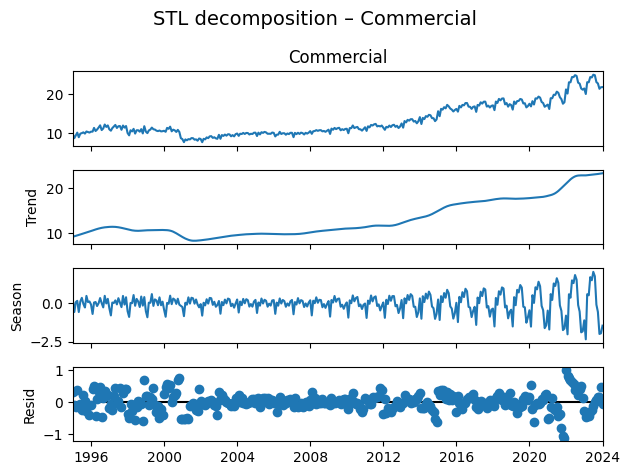

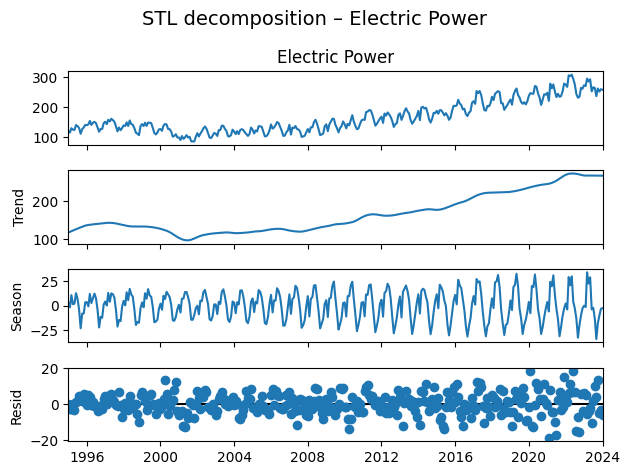

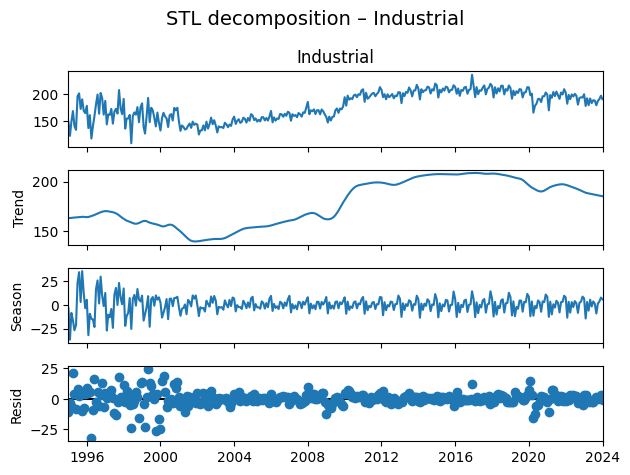

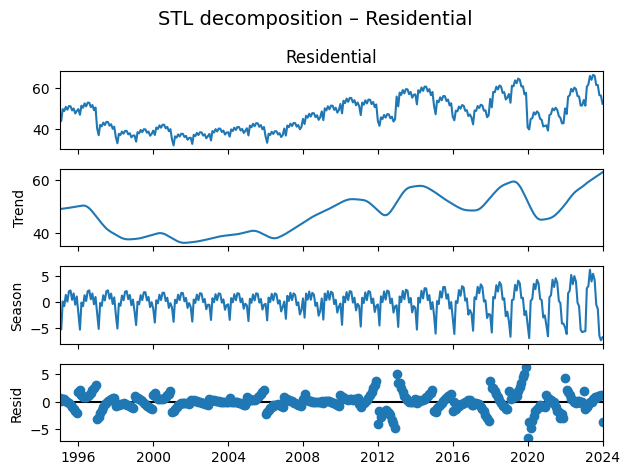

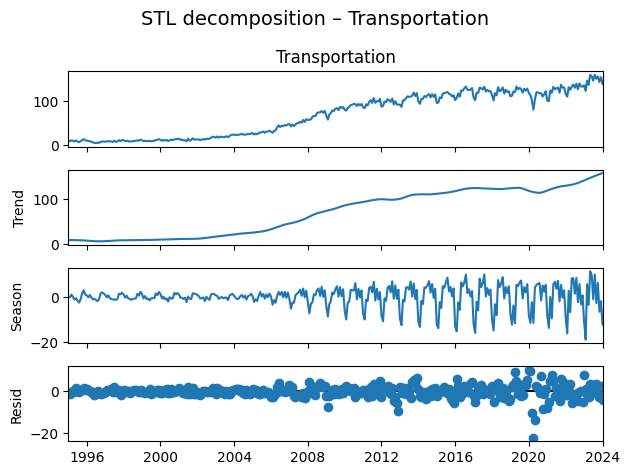

In [6]:
plot_stl(ts["Commercial"], period=12,
         title="STL decomposition – Commercial")

plot_stl(ts["Electric Power"], period=12,
         title="STL decomposition – Electric Power")

plot_stl(ts["Industrial"], period=12,
         title="STL decomposition – Industrial")

plot_stl(ts["Residential"], period=12,
         title="STL decomposition – Residential")

plot_stl(ts["Transportation"], period=12,
         title="STL decomposition – Transportation")

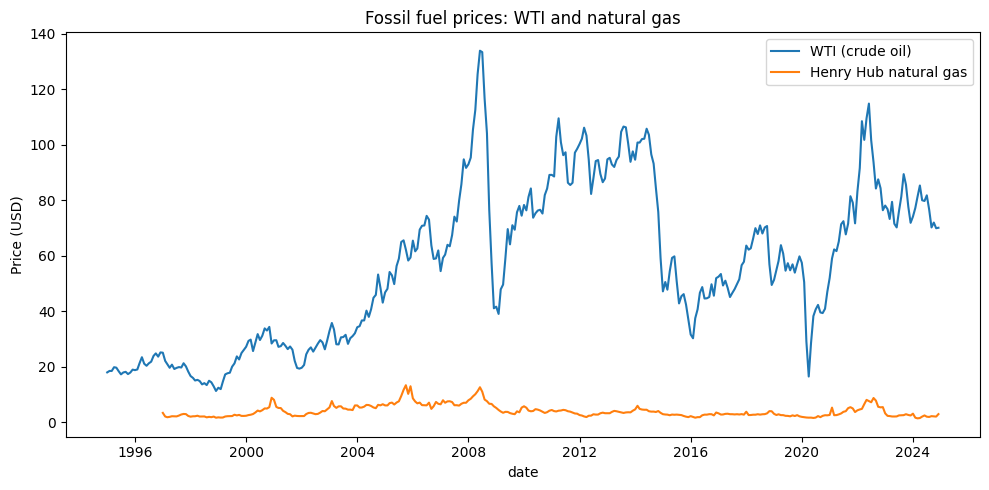

In [7]:
macro = pd.read_csv(MACRO_PATH, parse_dates=["date"])
macro.set_index("date", inplace=True)

plt.figure(figsize=(10, 5))
plt.plot(macro.index, macro["WTI"], label="WTI (crude oil)")
plt.plot(macro.index, macro["gas"], label="Henry Hub natural gas")
plt.title("Fossil fuel prices: WTI and natural gas")
plt.xlabel("date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(series, lags=36, title_prefix=""):
    """Return ACF/PACF figure without closing it."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(series, lags=lags, ax=axes[0])
    plot_pacf(series, lags=lags, ax=axes[1], method="ywm")

    axes[0].set_title(f"{title_prefix} – ACF")
    axes[1].set_title(f"{title_prefix} – PACF")

    plt.tight_layout()
    return fig

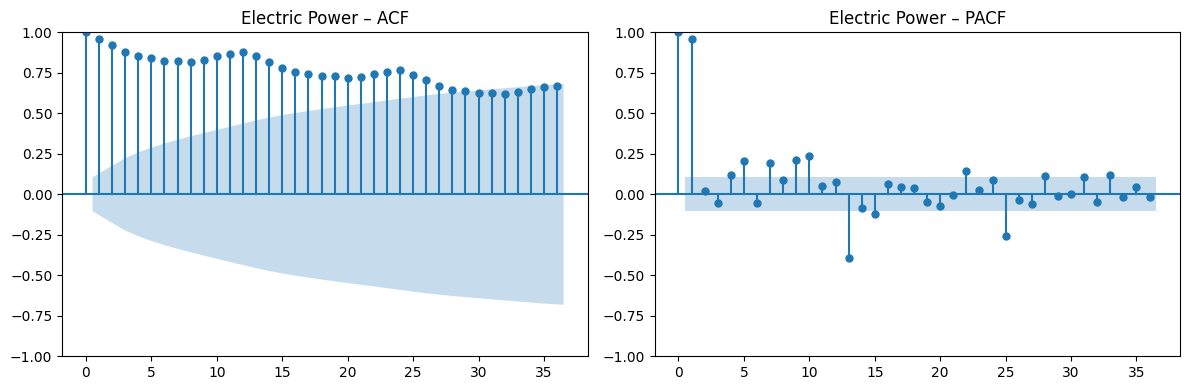

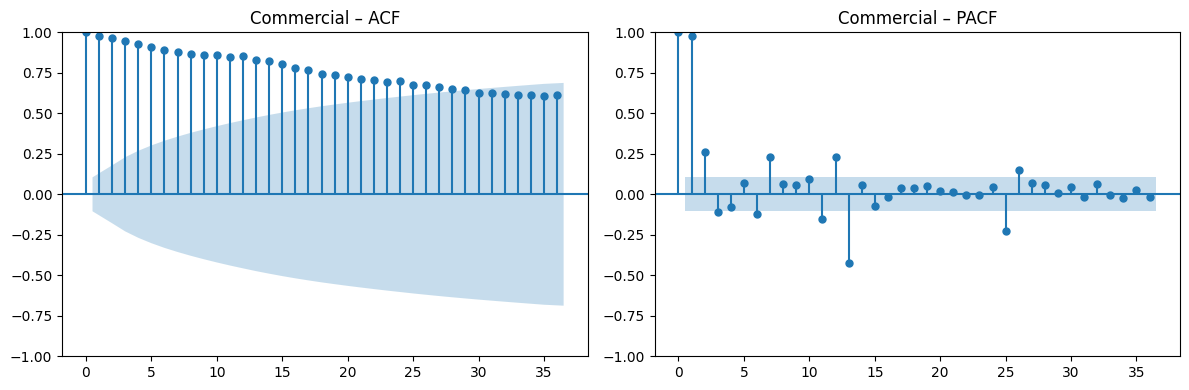

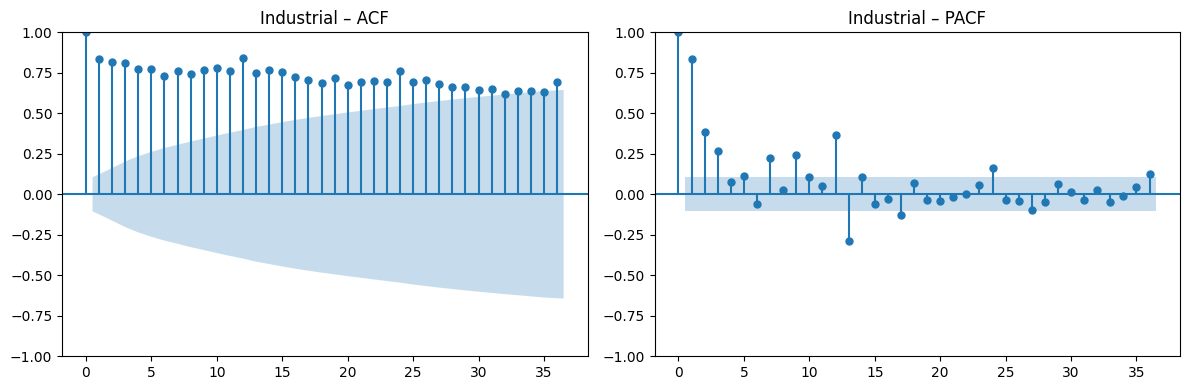

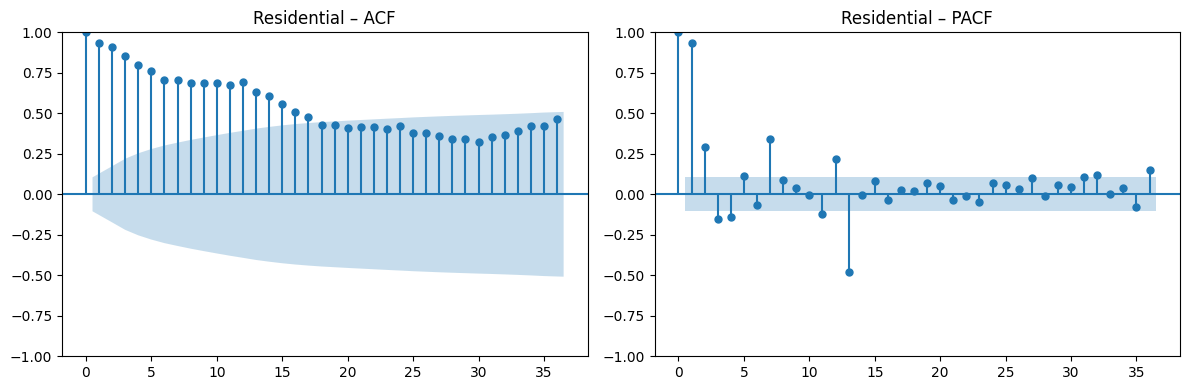

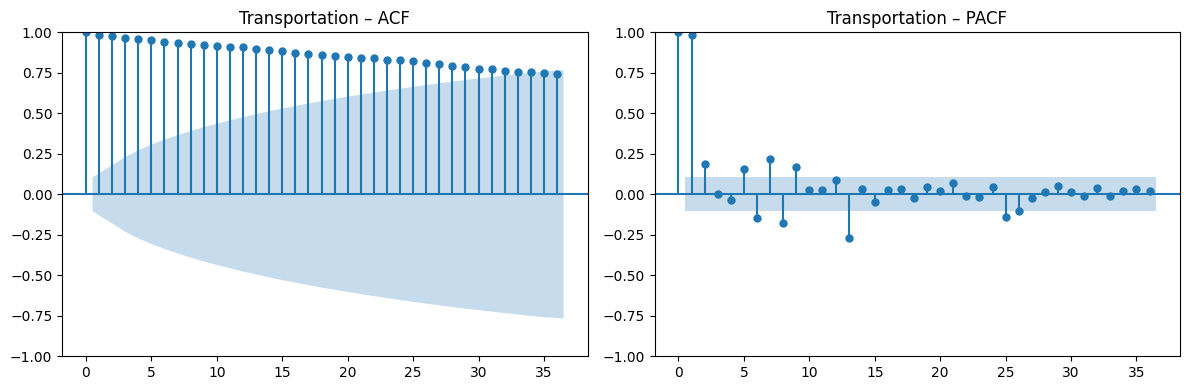

In [9]:
out_dir = Path("outputs/plots/ACF_PACF")
out_dir.mkdir(parents=True, exist_ok=True)

fig = plot_acf_pacf(ts["Electric Power"], lags=36, title_prefix="Electric Power")
fig.savefig(out_dir / "ElectricPower.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Commercial"], lags=36, title_prefix="Commercial")
fig.savefig(out_dir / "Commercial.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Industrial"], lags=36, title_prefix="Industrial")
fig.savefig(out_dir / "Industrial.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Residential"], lags=36, title_prefix="Residential")
fig.savefig(out_dir / "Residential.png", dpi=300)
plt.show()
fig = plot_acf_pacf(ts["Transportation"], lags=36, title_prefix="Transportation")
fig.savefig(out_dir / "Transportation.png", dpi=300)
plt.show()

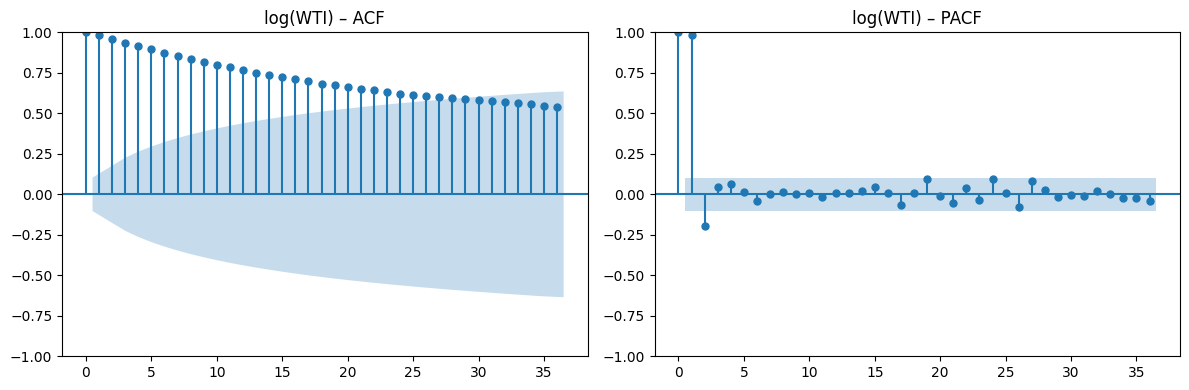

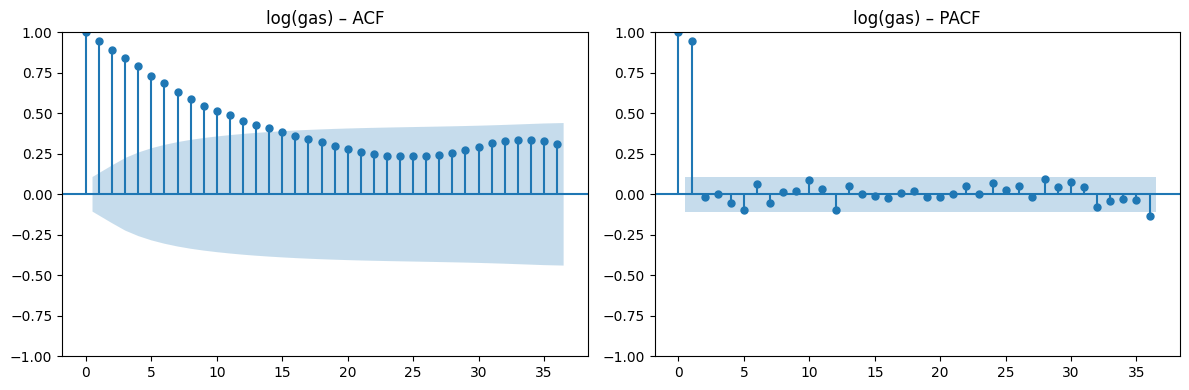

In [10]:
out_dir = Path("outputs/plots/ACF_PACF")
out_dir.mkdir(parents=True, exist_ok=True)

macro_log = pd.DataFrame({
    "log_WTI": np.log(macro["WTI"]),
    "log_gas": np.log(macro["gas"])
})

# WTI
fig = plot_acf_pacf(macro_log["log_WTI"].dropna(), lags=36, title_prefix="log(WTI)")
fig.savefig(out_dir / "WTI.png", dpi=300)
plt.show()

# Gas
fig = plot_acf_pacf(macro_log["log_gas"].dropna(), lags=36, title_prefix="log(gas)")
fig.savefig(out_dir / "gas.png", dpi=300)
plt.show()


The ACF and PACF plots confirm strong persistence and seasonal structure in several sectors (notably Residential and Electric Power), consistent with the presence of long-run growth and yearly cycles. Transportation shows negligible seasonality after the biofuel adjustment. The volatility of WTI and natural gas prices is reflected in jagged ACF/PACF patterns, indicating weak predictability and helping explain the poor performance of the VAR-X model.

In [11]:
out_dir = Path("outputs/plots/RMSFE")
out_dir.mkdir(parents=True, exist_ok=True)

# Carica i risultati dei modelli
fs   = pd.read_csv("outputs/forecast_summary.csv").set_index("Series")
var  = pd.read_csv("outputs/forecast_summary_var.csv").set_index("Series")
varx = pd.read_csv("outputs/forecast_summary_varx.csv").set_index("Series")

metrics = pd.DataFrame({
    "RMSFE_sNaive": fs["RMSFE_sNaive"],
    "RMSFE_RW":     fs["RMSFE_RW"],
    "RMSFE_ARIMA":  fs["RMSFE_ARIMA"],
    "RMSFE_SARIMA": fs["RMSFE_SARIMA"],
    "RMSFE_VAR":    var["RMSFE_VAR"],
    "RMSFE_VARX":   varx["RMSFE_VARX"],
})

metrics.to_csv(out_dir / "RMSFE_comparison_table.csv", float_format="%.4f")

metrics

,RMSFE_sNaive,RMSFE_RW,RMSFE_ARIMA,RMSFE_SARIMA,RMSFE_VAR,RMSFE_VARX
Series,,,,,,
Commercial,17.020,16.971,16.975,16.967,1.054,4.121
Residential,50.489,50.446,50.447,50.445,3.328,6.576
Transportation,124.180,124.145,124.147,124.144,10.826,24.276
Industrial,190.900,190.916,190.911,190.912,21.185,22.682
Electric Power,244.002,243.971,243.971,243.965,21.572,51.305


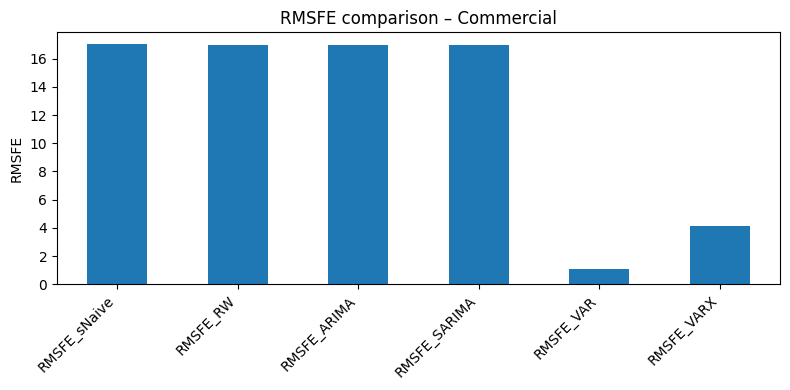

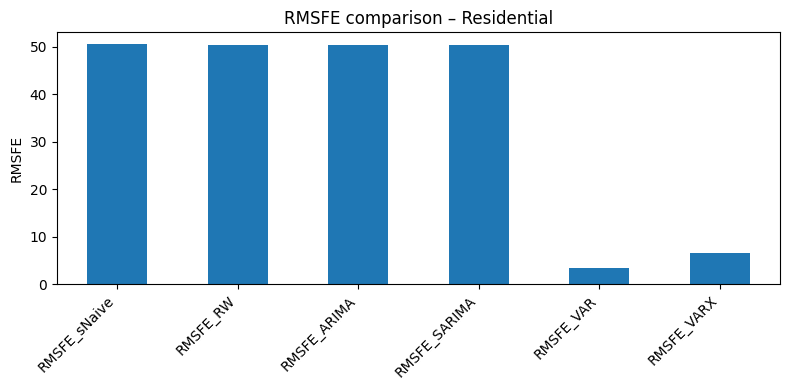

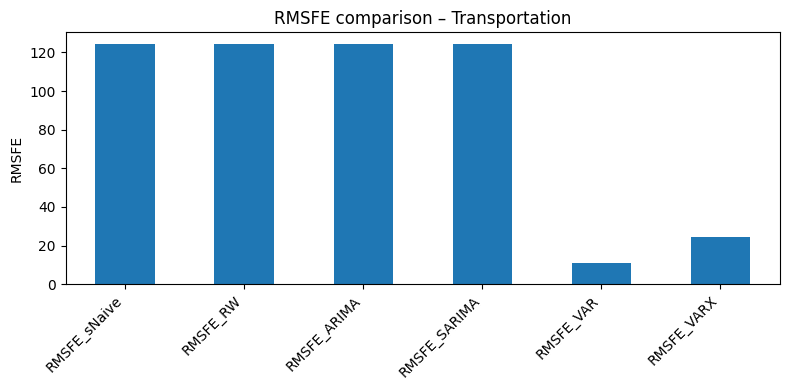

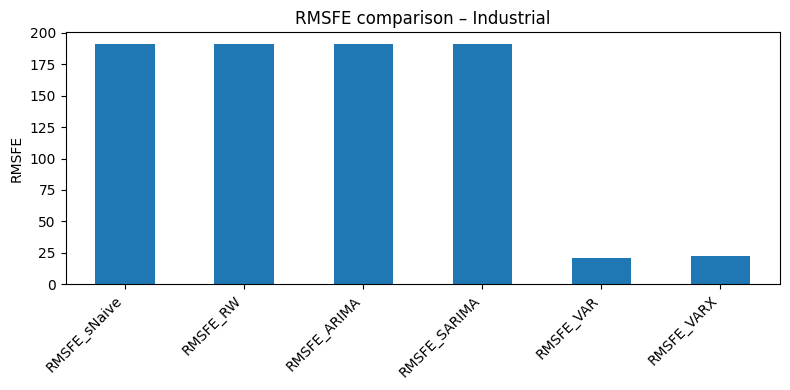

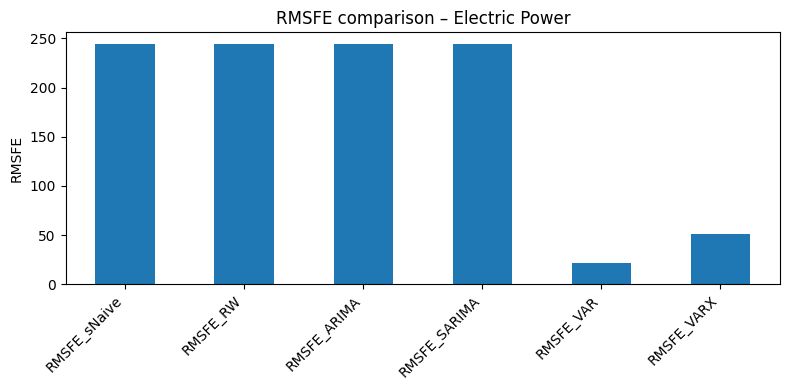

In [12]:
out_dir = Path("outputs/plots/RMSFE")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in metrics.index:
    plt.figure(figsize=(8, 4))
    metrics.loc[sector].plot(kind="bar")
    plt.title(f"RMSFE comparison – {sector}")
    plt.ylabel("RMSFE")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_dir / f"rmsfe_{sector.replace(' ', '_')}.png", dpi=300)
    plt.show()

In [13]:
def plot_actual_vs_bench(ts: pd.DataFrame, sector: str):
    """
    Per ogni settore, identifica il benchmark con RMSFE più basso
    tra sNaive, RW, ARIMA, SARIMA, ricomputa le previsioni e plotta
    actual vs forecast sul test set.
    """
    # choose best model
    row = fs.loc[sector]
    rmsfe_map = {
        "sNaive": "RMSFE_sNaive",
        "RW":     "RMSFE_RW",
        "ARIMA":  "RMSFE_ARIMA",
        "SARIMA": "RMSFE_SARIMA",
    }
    best_name = min(rmsfe_map, key=lambda k: row[rmsfe_map[k]])
    best_rmsfe = row[rmsfe_map[best_name]]
    
    # sector in levels and log-transformation
    y_raw = ts[sector].dropna()
    y_t, logged = maybe_log_transform(y_raw)
    
    # split train/test
    h = max(1, int(round(len(y_t) * TEST_SIZE_RATIO)))
    test_index = y_t.index[-h:]
    
    # log previsions for each benchmark
    ARIMA_ORDER_GRID = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1)]

    yhat_s = seasonal_naive(y_t).loc[test_index]
    yhat_rw = forecast_rw_recursive(y_t).loc[test_index]
    yhat_ar, _ = forecast_arima_recursive(y_t, ARIMA_ORDER_GRID)
    yhat_ar = yhat_ar.loc[test_index]
    yhat_sar, _, _ = forecast_sarima_recursive(y_t)
    yhat_sar = yhat_sar.loc[test_index]

    preds_log = {
        "sNaive": yhat_s,
        "RW":     yhat_rw,
        "ARIMA":  yhat_ar,
        "SARIMA": yhat_sar,
    }

    yhat_best_log = preds_log[best_name]
    
    # back to levels for the plot
    y_test = y_raw.loc[test_index]
    if logged:
        yhat_best = invert_log_transform(yhat_best_log, True)
    else:
        yhat_best = yhat_best_log
    
    # plot
    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(y_test.index, y_test.values, label="Actual")
    ax.plot(yhat_best.index, yhat_best.values,
            label=f"{best_name} forecast")

    ax.set_title(f"{sector} – best benchmark: {best_name} (RMSFE={best_rmsfe:.2f})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    return fig  

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

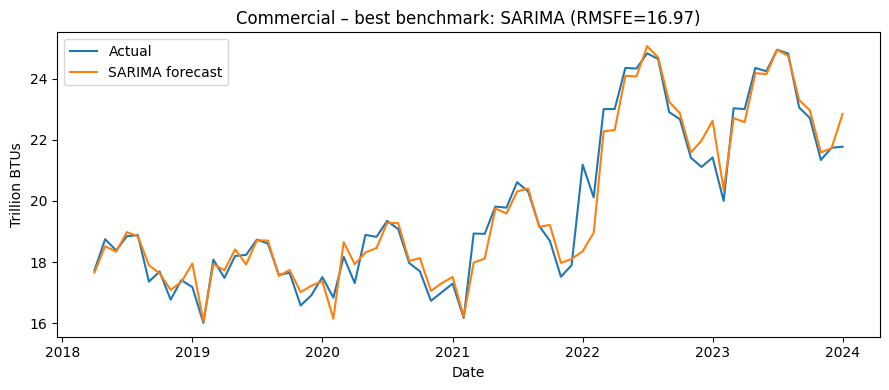

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. 

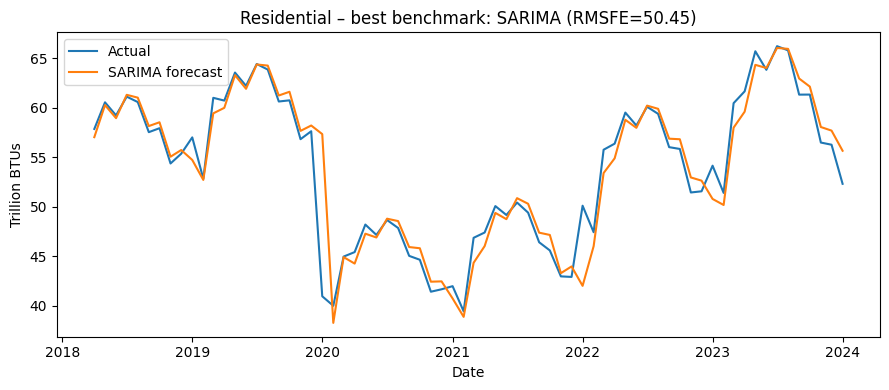

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starti

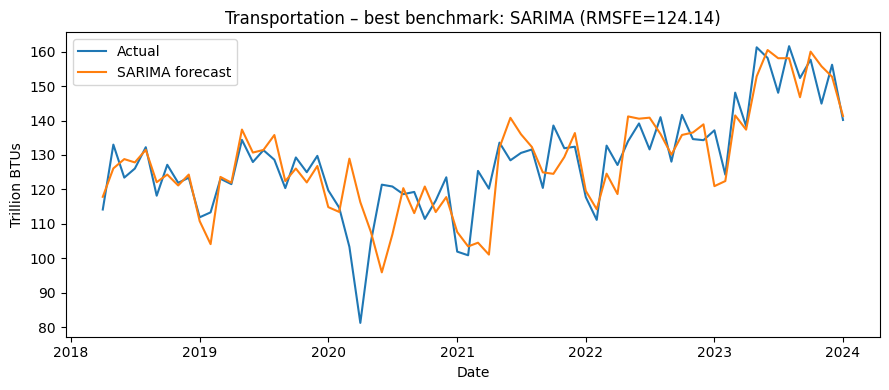

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

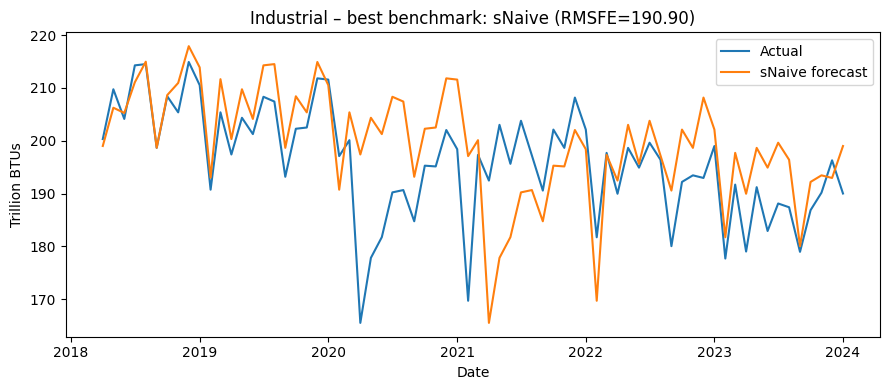

c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Leila\PycharmProjects\time_series_forecasting\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starti

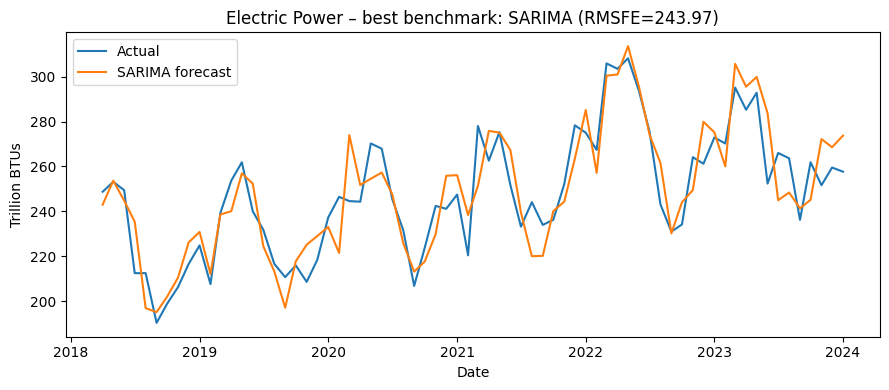

In [14]:
out_dir = Path("outputs/plots/actual_vs_best_benchmark")
out_dir.mkdir(parents=True, exist_ok=True)

for sector in VAR_SECTOR_COLS:
    fig = plot_actual_vs_bench(ts, sector)
    fname = sector.replace(" ", "_") + "_best_benchmark.png"
    fig.savefig(out_dir / fname, dpi=300)
    plt.show()

In [15]:
def plot_actual_vs_var(ts: pd.DataFrame, sector: str):
    """Stima un VAR e restituisce la figura actual vs forecast (test) per un settore."""
    y_test, y_hat = forecast_var_recursive(
        ts=ts,
        target_col=sector,
        var_cols=VAR_SECTOR_COLS,
        test_size_ratio=TEST_SIZE_RATIO,
        maxlags=VAR_LAGS,
    )

    fig, ax = plt.subplots(figsize=(9, 4))
    ax.plot(y_test.index, y_test.values, label="Actual")
    ax.plot(y_test.index, y_hat.values, label="VAR forecast")

    ax.set_title(f"{sector} – actual vs VAR forecast (test sample)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Trillion BTUs")
    ax.legend()
    fig.tight_layout()

    print(f"RMSFE_VAR ({sector}): {rmsfe(y_test, y_hat):.3f}")

    return fig

RMSFE_VAR (Electric Power): 21.572


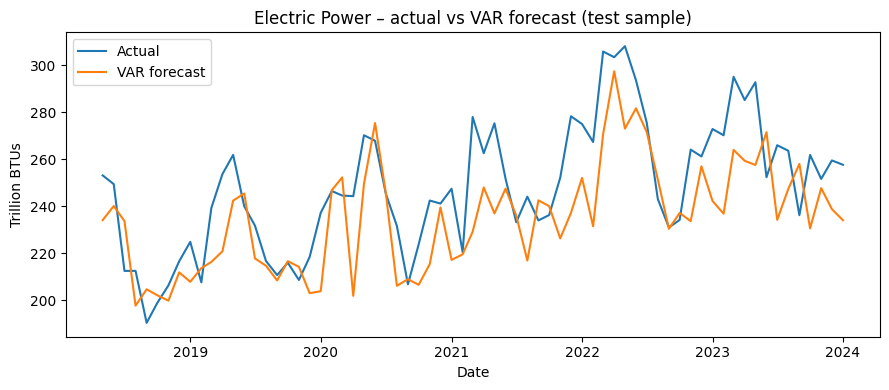

RMSFE_VAR (Transportation): 10.826


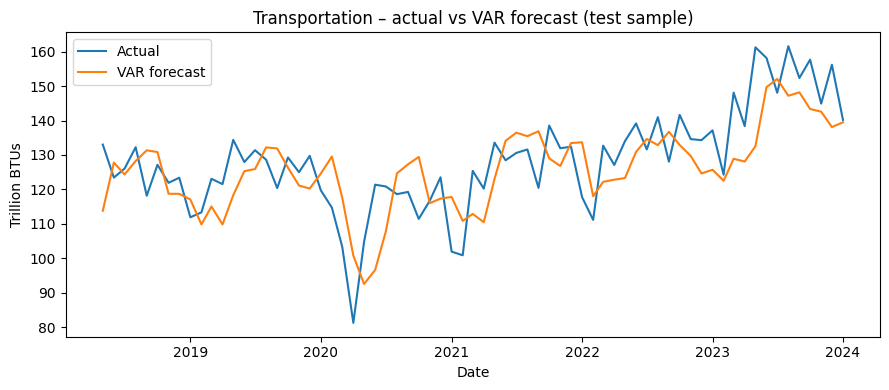

RMSFE_VAR (Residential): 3.328


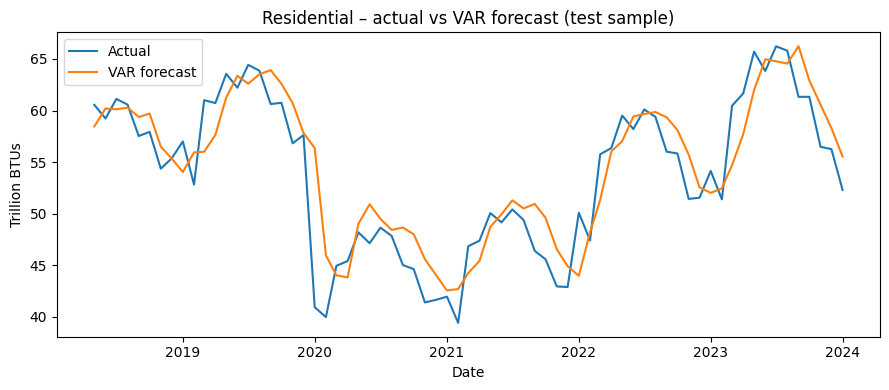

RMSFE_VAR (Commercial): 1.054


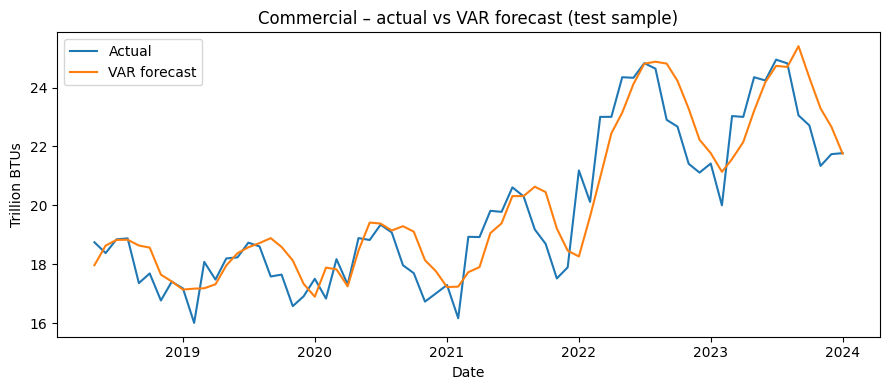

RMSFE_VAR (Industrial): 21.185


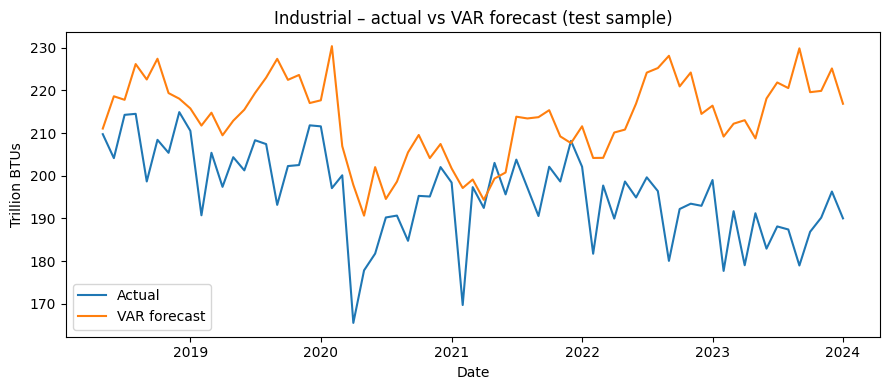

In [16]:
out_dir = Path("outputs/plots/actual_vs_VAR")
out_dir.mkdir(parents=True, exist_ok=True)

fig = plot_actual_vs_var(ts, "Electric Power")
fig.savefig(out_dir / "ElectricPower_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Transportation")
fig.savefig(out_dir / "Transportation_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Residential")
fig.savefig(out_dir / "Residential_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Commercial")
fig.savefig(out_dir / "Commercial_var.png", dpi=300)
plt.show()

fig = plot_actual_vs_var(ts, "Industrial")
fig.savefig(out_dir / "Industrial_var.png", dpi=300)
plt.show()